# NIS Codes
De NIS-code (Frans: code INS) is een alfanumerieke code voor geografische gebieden die toegepast wordt voor statistische verwerkingen in België. Deze code werd in het midden van de jaren 60 ontwikkeld door het Nationaal Instituut voor de Statistiek (NIS) (nu Statbel) en ze werd voor het eerst gebruikt tijdens de volkstelling van 1970. (wikipedia)

Een NIS-code bestaat uit 5 cijfers:
- eerste cijfer bevat de provincie. Wanneer de overige 4 cijfers nullen zijn, verwijst de code naar de provincie zelf. Bijvoorbeeld 10000 verwijst naar de provincie Antwerpen (probleem: er zijn 10 provincies in België)
- tweede cijfer bevat het arondissement. Wanneer de overige 2 cijfers nullen zijn, verwijst de code naar het arrondissement zelf. Bijvoorbeeld 24000 verwijst naar het arrondissement Leuven
- de drie laatste cijfers verwijzen naar een gemeente
Enkele speciale codes
- België heeft de code 01000
- Het Vlaamse gewest kreeg code 02000
- Het Waalse gewest kreeg code 03000
- Het Brusselse gewest kreeg code 04000
- In 1995 werd de provincie Brabant (oorspronkelijk NIS-code 20000) gesplitst in Vlaams-Brabant (NIS-code 20001) en Waals-Brabant (NIS-code 20002). De nummers van de arrondissementen en de gemeenten in de vroegere provincie Brabant, zijn niet veranderd. Bijvoorbeeld de stad Leuven heeft NIS-code 24062 (Vroegere provincie Brabant: 2, arrodissement Leuven 4, stad Leuven 062)


## Download van het bestand en structuur
De links naar de open-data staan op [de website van Statbel](https://statbel.fgov.be/nl/open-data/refnis-code). We kunnen een CSV-bestand als ZIP-bestand downloaden (eigenlijk een .TXT-bestand) en een XLSX-bestand. We zullen werken met het ZIP-bestand


In [1]:
from zipfile import ZipFile
import requests
URL = 'https://statbel.fgov.be/sites/default/files/files/opendata/REFNIS%20code/TU_COM_REFNIS.zip'
REFNIS_ZIP = 'TU_COM_REFNIS.zip'
data = requests.get(URL)
with open(REFNIS_ZIP, 'wb') as f:
    f.write(data.content)
with open(REFNIS_ZIP, 'rb') as f:
    ZipFile(f).extractall()

Ik vind het altijd een goed idee om een bestand te lezen met Python

In [2]:
REFNIS_TXT = 'TU_COM_REFNIS.txt'
with open(REFNIS_TXT) as f:
    for _ in range(5):
        print(f.readline())

ï»¿LVL_REFNIS|CD_REFNIS|CD_SUP_REFNIS|TX_REFNIS_DE|TX_REFNIS_FR|TX_REFNIS_NL|DT_VLDT_START|DT_VLDT_END

1|02000|-|FlÃ¤mische Region|RÃ©gion flamande|Vlaams Gewest|01/01/1970|31/12/9999

1|03000|-|Wallonische Region|RÃ©gion wallonne|Waals Gewest|01/01/1970|31/12/9999

1|04000|-|Region BrÃ¼ssel-Hauptstadt|RÃ©gion de Bruxelles-Capitale|Brussels Hoofdstedelijk Gewest|01/01/1970|31/12/9999

2|10000|02000|Provinz Antwerpen|Province d'Anvers|Provincie Antwerpen|01/01/1970|31/12/9999



Er is blijkbaar een probleem met de encoding. Ik herken ï»¿ als eerste teken. (ervaring) Dat is een Byte-Order-Mark (BOM) (hexadecimale codes 0xEF, 0xBB, 0xBF). In Python moeten we het bestand lezen met de encoding 'UTF-8-SIG'

In [3]:
REFNIS_TXT = 'TU_COM_REFNIS.txt'
with open(REFNIS_TXT, encoding='UTF-8-SIG') as f:
    for _ in range(5):
        print(f.readline())

LVL_REFNIS|CD_REFNIS|CD_SUP_REFNIS|TX_REFNIS_DE|TX_REFNIS_FR|TX_REFNIS_NL|DT_VLDT_START|DT_VLDT_END

1|02000|-|Flämische Region|Région flamande|Vlaams Gewest|01/01/1970|31/12/9999

1|03000|-|Wallonische Region|Région wallonne|Waals Gewest|01/01/1970|31/12/9999

1|04000|-|Region Brüssel-Hauptstadt|Région de Bruxelles-Capitale|Brussels Hoofdstedelijk Gewest|01/01/1970|31/12/9999

2|10000|02000|Provinz Antwerpen|Province d'Anvers|Provincie Antwerpen|01/01/1970|31/12/9999



## Inlezen in dataframe
We zullen de volgende 'regels' hanteren:
1. We maken 4 dataframes: de gewesten, de provincies, de arrondissementen en de gemeenten (op basis van de eerste kolom)
1. België heeft drie gewesten: het Vlaamse gewest, het Waalse gewest en het Brussels Hoofdstedelijk gewest.
1. Elk gewest (behalve het Brusselse) is onderverdeeld in provincies. (10 provincies: 5 Vlaamse en 5 Waalse)
1. Vroeger waren er 9 provincies. De provincie Brabant is opgesplitst in Vlaams-Brabant (Vlaams gewest) en Waals-Brabant (Waals gewest)
1. Elke provincie is onderverdeeld in een aantal arrondissementen
1. De gemeenten liggen in een bepaald arrondissement
1. De kolom CD_REFNIS duidt aan waar een item ligt: bij een gemeente verwijst het naar het arrondissement, bij een arrondissement verwijst het naar een provincie, bij een provincie verwijst het naar een gewest.
1. Voor de gewesten gebruiken we de kolom CD_REFNIS niet. (het '-'-teken)
1. De twee laatste kolommen bevatten de 'geldigheidsduur': van-tot. Omdat gemeenten soms samengevoegd worden, verdwijnen sommige gemeenten na een tijdje. Voor de provincie Brabant geldt dat ook. Ze hield op te bestaan op 31 december 1994.
Om niet teveel ineens te doen, lezen we eerst het volledige dataframe in.

In [2]:
import pandas as pd
REFNIS_TXT = 'TU_COM_REFNIS.txt'
df = pd.read_csv(REFNIS_TXT, delimiter='|', parse_dates=['DT_VLDT_START', 'DT_VLDT_END'], 
                 date_format='%d/%m/%Y')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   LVL_REFNIS     2769 non-null   int64         
 1   CD_REFNIS      2769 non-null   int64         
 2   CD_SUP_REFNIS  2769 non-null   object        
 3   TX_REFNIS_DE   2769 non-null   object        
 4   TX_REFNIS_FR   2769 non-null   object        
 5   TX_REFNIS_NL   2769 non-null   object        
 6   DT_VLDT_START  2769 non-null   datetime64[ns]
 7   DT_VLDT_END    2769 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 173.2+ KB


,LVL_REFNIS,CD_REFNIS,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
0,1,2000,-,Flämische Region,Région flamande,Vlaams Gewest,1970-01-01,31/12/9999
1,1,3000,-,Wallonische Region,Région wallonne,Waals Gewest,1970-01-01,31/12/9999
2,1,4000,-,Region Brüssel-Hauptstadt,Région de Bruxelles-Capitale,Brussels Hoofdstedelijk Gewest,1970-01-01,31/12/9999
3,2,10000,02000,Provinz Antwerpen,Province d'Anvers,Provincie Antwerpen,1970-01-01,31/12/9999
4,2,20000,-,Provinz Brabant,Province de Brabant,Provincie Brabant,1970-01-01,31/12/1994


Waarom worden CD_REFNIS en DT_VLDT_END niet correct ingelezen? 
- CD_REFNIS wordt herkend als een int64 terwijl het eigenlijk een code is. Die moet ingelezen worden als string
- Voor DT_VLDT_END is het probleem dat 31/12/9999 een ongeldige datum is. We kunnen die vervangen door NaT. 
Aangezien we de kolomnamen nu al hebben, kunnen we die gebruiken om de dictionary te maken met pd.StringDtype

In [3]:
import pandas as pd
REFNIS_TXT = 'TU_COM_REFNIS.txt'
kolommen = df.columns[1:-3]
dtypes = {key:pd.StringDtype() for key in kolommen}
df = pd.read_csv(REFNIS_TXT, delimiter='|', parse_dates=['DT_VLDT_START', 'DT_VLDT_END'], 
                 date_format='%d/%m/%Y', na_values='31/12/9999', dtype=dtypes)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   LVL_REFNIS     2769 non-null   int64         
 1   CD_REFNIS      2769 non-null   string        
 2   CD_SUP_REFNIS  2769 non-null   string        
 3   TX_REFNIS_DE   2769 non-null   string        
 4   TX_REFNIS_FR   2769 non-null   string        
 5   TX_REFNIS_NL   2769 non-null   object        
 6   DT_VLDT_START  2769 non-null   datetime64[ns]
 7   DT_VLDT_END    2132 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), string(4)
memory usage: 173.2+ KB


,LVL_REFNIS,CD_REFNIS,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
0,1,02000,-,Flämische Region,Région flamande,Vlaams Gewest,1970-01-01,NaT
1,1,03000,-,Wallonische Region,Région wallonne,Waals Gewest,1970-01-01,NaT
2,1,04000,-,Region Brüssel-Hauptstadt,Région de Bruxelles-Capitale,Brussels Hoofdstedelijk Gewest,1970-01-01,NaT
3,2,10000,02000,Provinz Antwerpen,Province d'Anvers,Provincie Antwerpen,1970-01-01,NaT
4,2,20000,-,Provinz Brabant,Province de Brabant,Provincie Brabant,1970-01-01,1994-12-31


## Een dataframe voor de gewesten
De gewesten hebben LVL_REFNIS 1. We zullen CD_REFNIS als index gebruiken. De kolom CD_SUP_REFNIS hebben we niet nodig. 

In [7]:
df_gewesten = df.loc[df.LVL_REFNIS==1, df.columns[[1, 3, 4, 5, 6, 7]]].copy()
df_gewesten = df_gewesten.set_index('CD_REFNIS')
display(df_gewesten.head())

,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
CD_REFNIS,,,,,
02000,Flämische Region,Région flamande,Vlaams Gewest,1970-01-01,NaT
03000,Wallonische Region,Région wallonne,Waals Gewest,1970-01-01,NaT
04000,Region Brüssel-Hauptstadt,Région de Bruxelles-Capitale,Brussels Hoofdstedelijk Gewest,1970-01-01,NaT


## Een dateframe voor de provincies
We moeten opletten met de provincie Brabant (CD_REFNIS: 20000). Die bestaat niet meer. Dat zien we ook aan DT_VLDT_END (31/12/1994). We zouden die eruit kunnen filteren, maar aangezien we daarvoor DT_VLDT_END kunnen gebruiken, zullen we die toch opnemen. We moeten dus alleen filteren op LVL_REFNIS=2

In [ ]:
df_provincies = df.loc[df.LVL_REFNIS==2, df.columns[1:]].copy()
df_provincies = df_provincies.set_index('CD_REFNIS')
df_provincies.head(11)

,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
CD_REFNIS,,,,,,
10000,02000,Provinz Antwerpen,Province d'Anvers,Provincie Antwerpen,1970-01-01,NaT
20000,-,Provinz Brabant,Province de Brabant,Provincie Brabant,1970-01-01,1994-12-31
20001,02000,Provinz Flämisch-Brabant,Province du Brabant flamand,Provincie Vlaams-Brabant,1995-01-01,NaT
20002,03000,Provinz Wallonisch-Brabant,Province du Brabant wallon,Provincie Waals-Brabant,1995-01-01,NaT
30000,02000,Provinz Westflandern,Province de Flandre occidentale,Provincie West-Vlaanderen,1970-01-01,NaT
40000,02000,Provinz Ostflandern,Province de Flandre orientale,Provincie Oost-Vlaanderen,1970-01-01,NaT
50000,03000,Provinz Hennegau,Province du Hainaut,Provincie Henegouwen,1970-01-01,NaT
60000,03000,Provinz Lüttich,Province de Liège,Provincie Luik,1970-01-01,NaT
70000,02000,Provinz Limburg,Province du Limbourg,Provincie Limburg,1970-01-01,NaT


## Een dataframe voor de arrondissementen

In [11]:
df_arrondissementen = df.loc[df.LVL_REFNIS==3, df.columns[1:]].copy()
df_arrondissementen = df_arrondissementen.set_index('CD_REFNIS')
df_arrondissementen.head(10)

,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
CD_REFNIS,,,,,,
11000,10000,Bezirk Antwerpen,Arrondissement d'Anvers,Arrondissement Antwerpen,1970-01-01,NaT
12000,10000,Bezirk Mechelen,Arrondissement de Malines,Arrondissement Mechelen,1970-01-01,NaT
13000,10000,Bezirk Turnhout,Arrondissement de Turnhout,Arrondissement Turnhout,1970-01-01,NaT
21000,04000,Bezirk Brüssel-Hauptstadt,Arrondissement de Bruxelles-Capitale,Arrondissement Brussel-Hoofdstad,1970-01-01,NaT
23000,20001,Bezirk Halle-Vilvoorde,Arrondissement de Hal-Vilvorde,Arrondissement Halle-Vilvoorde,1995-01-01,NaT
23000,20000,Bezirk Halle-Vilvoorde,Arrondissement de Hal-Vilvorde,Arrondissement Halle-Vilvoorde,1970-01-01,1994-12-31
24000,20001,Bezirk Löwen,Arrondissement de Louvain,Arrondissement Leuven,1995-01-01,NaT
24000,20000,Bezirk Löwen,Arrondissement de Louvain,Arrondissement Leuven,1970-01-01,1994-12-31
25000,20002,Bezirk Nivelles,Arrondissement de Nivelles,Arrondissement Nijvel,1995-01-01,NaT


## En tenslotte de gemeenten

In [14]:
df_gemeenten = df.loc[df.LVL_REFNIS==4, df.columns[1:]].copy()
df_gemeenten = df_gemeenten.set_index('CD_REFNIS')
df_gemeenten.head(10)

,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
CD_REFNIS,,,,,,
11001,11000,Aartselaar,Aartselaar,Aartselaar,1970-01-01,NaT
11002,11000,Antwerpen,Anvers,Antwerpen,1970-01-01,NaT
11003,11000,Berchem (Antwerpen),Berchem (Anvers),Berchem (Antwerpen),1970-01-01,1982-12-31
11004,11000,Boechout,Boechout,Boechout,1970-01-01,NaT
11005,11000,Boom,Boom,Boom,1970-01-01,NaT
11006,11000,Borgerhout,Borgerhout,Borgerhout,1970-01-01,1982-12-31
11007,11000,Borsbeek,Borsbeek,Borsbeek,1970-01-01,NaT
11008,11000,Brasschaat,Brasschaat,Brasschaat,1970-01-01,NaT
11009,11000,Brecht,Brecht,Brecht,1970-01-01,NaT


## De 'huidige' gemeenten
Na alle fusies in België kunnen we de lijst met de huidige nummers en gemeenten te pakken krijgen door de laatste kolom te controleren op NaT

In [15]:
df_huidige_gemeenten = df_gemeenten.loc[df_gemeenten.DT_VLDT_END.isna()]
df_huidige_gemeenten.info()
df_huidige_gemeenten.head()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, 11001 to 93090
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CD_SUP_REFNIS  581 non-null    string        
 1   TX_REFNIS_DE   581 non-null    string        
 2   TX_REFNIS_FR   581 non-null    string        
 3   TX_REFNIS_NL   581 non-null    object        
 4   DT_VLDT_START  581 non-null    datetime64[ns]
 5   DT_VLDT_END    0 non-null      datetime64[ns]
dtypes: datetime64[ns](2), object(1), string(3)
memory usage: 31.8+ KB


,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
CD_REFNIS,,,,,,
11001,11000,Aartselaar,Aartselaar,Aartselaar,1970-01-01,NaT
11002,11000,Antwerpen,Anvers,Antwerpen,1970-01-01,NaT
11004,11000,Boechout,Boechout,Boechout,1970-01-01,NaT
11005,11000,Boom,Boom,Boom,1970-01-01,NaT
11007,11000,Borsbeek,Borsbeek,Borsbeek,1970-01-01,NaT


### De Oostkantons
In het oosten van de provincie Luik liggen de zogenaamde 'oostkantons'. Dat is het gebied dat tot de Duitstalige gemeenschap van België behoort. Die oostkantons worden soms ook ook aangeduid met de naam van de drie grootste gemeenten: Eupen-Malmédy-Sankt Vith. 

### Enkele vraagjes over de oostkantons
Wat is de CD_REFNIS van Eupen?
Wat is de Duitse naam van het arrondissement waarin Eupen ligt?
Maak een lijst met alle gemeenten die in hetzelfde arrondissement als Eupen liggen  

In [ ]:
cd_refnis_eupen = df_huidige_gemeenten[df_huidige_gemeenten.TX_REFNIS_DE=='Eupen'].index
print(cd_refnis_eupen.)

Index(['63023'], dtype='string', name='CD_REFNIS')


In [20]:
cd_sup_refnis_eupen = df_huidige_gemeenten.loc[cd_refnis_eupen, 'CD_SUP_REFNIS'].iloc[0]
print(cd_sup_refnis_eupen)

63000


In [23]:
arrondissement_eupen = df_arrondissementen.loc[cd_sup_refnis_eupen, 'TX_REFNIS_DE']
print(arrondissement_eupen)

Bezirk Verviers


In [24]:
gemeenten = df_huidige_gemeenten.loc[df_huidige_gemeenten.CD_SUP_REFNIS==cd_sup_refnis_eupen, 'TX_REFNIS_DE']
print(gemeenten)

CD_REFNIS
63001                  Amel
63003                 Aubel
63004                Baelen
63012             Büllingen
63013            Bütgenbach
63020                 Dison
63023                 Eupen
63035                 Herve
63038                Jalhay
63040                Kelmis
63045              Lierneux
63046              Limbourg
63048               Lontzen
63049               Malmedy
63057                  Olne
63058             Pepinster
63061                Raeren
63067            Sankt Vith
63072                   Spa
63073              Stavelot
63075              Stoumont
63076                 Theux
63079              Verviers
63080               Weismes
63084           Welkenraedt
63086           Trois-Ponts
63087          Burg-Reuland
63088            Plombières
63089    Thimister-Clermont
Name: TX_REFNIS_DE, dtype: string


## Maak een staafdiagram met de provincies en het aantal gemeenten van die provincie

In [27]:
provincies = df_provincies.loc[df_provincies.DT_VLDT_END.isna(), 'TX_REFNIS_NL']
provincies

CD_REFNIS
10000          Provincie Antwerpen
20001     Provincie Vlaams-Brabant
20002      Provincie Waals-Brabant
30000    Provincie West-Vlaanderen
40000    Provincie Oost-Vlaanderen
50000         Provincie Henegouwen
60000               Provincie Luik
70000            Provincie Limburg
80000          Provincie Luxemburg
90000              Provincie Namen
Name: TX_REFNIS_NL, dtype: object

In [63]:
def get_provincie_nummer(index):
    return index[0]
provincie_groepen = df_huidige_gemeenten.groupby(get_provincie_nummer).size()
provincie_groepen

CD_REFNIS
1     69
2    111
3     64
4     60
5     69
6     84
7     42
8     44
9     38
dtype: int64

## Waarom heeft provincie 2 zoveel gemeenten?
Antwoord: dit is de combinatie van Vlaams-Brabant en Waals-Brabant. We kunnen die splitsen op de arrondissementen

In [31]:
vlaamse_arrondissementen= df_arrondissementen[df_arrondissementen.CD_SUP_REFNIS == '20001']
waalse_arrondissementen = df_arrondissementen[df_arrondissementen.CD_SUP_REFNIS == '20002']
vlaamse_arrondissementen.TX_REFNIS_NL, waalse_arrondissementen.TX_REFNIS_FR

(CD_REFNIS
 23000    Arrondissement Halle-Vilvoorde
 24000             Arrondissement Leuven
 Name: TX_REFNIS_NL, dtype: object,
 CD_REFNIS
 25000    Arrondissement de Nivelles
 Name: TX_REFNIS_FR, dtype: string)

In [ ]:
aantal_vlaamse_gemeenten = (df_huidige_gemeenten.loc[df_huidige_gemeenten.CD_SUP_REFNIS.isin(vlaamse_arrondissementen.index)]).shape[0]
aantal_waalse_gemeenten = (df_huidige_gemeenten.loc[df_huidige_gemeenten.CD_SUP_REFNIS.isin(waalse_arrondissementen.index)]).shape[0]


## Wie zijn we vergeten?

In [42]:
aantal_vlaamse_gemeenten + aantal_waalse_gemeenten

92

## Brussels gewest

In [46]:
df_arrondissementen[df_arrondissementen.CD_SUP_REFNIS == '04000']

,CD_SUP_REFNIS,TX_REFNIS_DE,TX_REFNIS_FR,TX_REFNIS_NL,DT_VLDT_START,DT_VLDT_END
CD_REFNIS,,,,,,
21000,04000,Bezirk Brüssel-Hauptstadt,Arrondissement de Bruxelles-Capitale,Arrondissement Brussel-Hoofdstad,1970-01-01,NaT


In [48]:
aantal_brusselse_gemeenten = (df_huidige_gemeenten.loc[df_huidige_gemeenten.CD_SUP_REFNIS=='21000']).shape[0]
aantal_brusselse_gemeenten + aantal_vlaamse_gemeenten + aantal_waalse_gemeenten

111

## Provinciegroepen updaten


In [64]:
provincie_groepen = provincie_groepen.drop(index='2')
provincie_groepen


CD_REFNIS
1    69
3    64
4    60
5    69
6    84
7    42
8    44
9    38
dtype: int64

In [65]:
provincie_groepen.index = provincie_groepen.index + '0000'
provincie_groepen

CD_REFNIS
10000    69
30000    64
40000    60
50000    69
60000    84
70000    42
80000    44
90000    38
dtype: int64

In [69]:
provincie_groepen['20001'] = aantal_vlaamse_gemeenten
provincie_groepen['20002'] = aantal_waalse_gemeenten
provincie_groepen['21000'] = aantal_brusselse_gemeenten
provincie_groepen.name='aantal'
provincie_groepen

CD_REFNIS
10000    69
30000    64
40000    60
50000    69
60000    84
70000    42
80000    44
90000    38
20001    65
20002    27
21000    19
Name: aantal, dtype: int64

## Voeg provincie_groepen samen met provincies (let op met Brussel)


In [73]:
provincie_groepen = pd.merge(provincie_groepen, provincies, left_index=True, right_index=True, how='outer')
provincie_groepen

,aantal,TX_REFNIS_NL
CD_REFNIS,,
10000,69,Provincie Antwerpen
20001,65,Provincie Vlaams-Brabant
20002,27,Provincie Waals-Brabant
21000,19,NaN
30000,64,Provincie West-Vlaanderen
40000,60,Provincie Oost-Vlaanderen
50000,69,Provincie Henegouwen
60000,84,Provincie Luik
70000,42,Provincie Limburg


In [84]:
provincie_groepen.loc['21000', 'TX_REFNIS_NL'] = df_arrondissementen.loc['21000', 'TX_REFNIS_NL']
provincie_groepen

,aantal,TX_REFNIS_NL
CD_REFNIS,,
10000,69,Provincie Antwerpen
20001,65,Provincie Vlaams-Brabant
20002,27,Provincie Waals-Brabant
21000,19,Arrondissement Brussel-Hoofdstad
30000,64,Provincie West-Vlaanderen
40000,60,Provincie Oost-Vlaanderen
50000,69,Provincie Henegouwen
60000,84,Provincie Luik
70000,42,Provincie Limburg


## Plot de gegevens

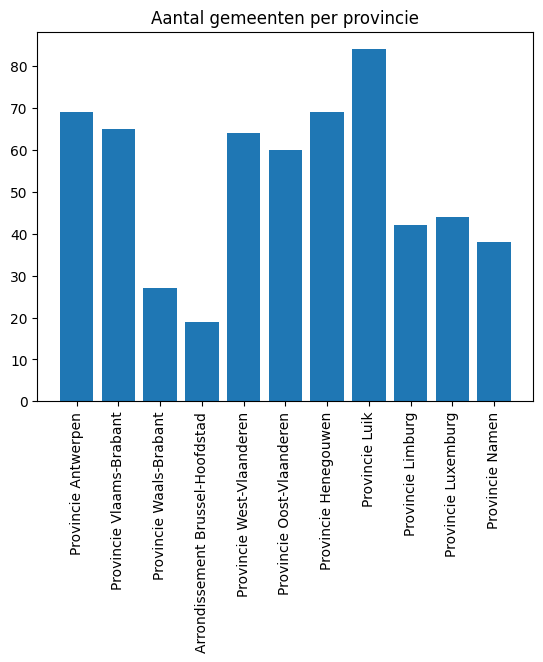

In [88]:
import matplotlib.pyplot as plt
plt.bar(provincie_groepen.TX_REFNIS_NL, provincie_groepen.aantal)
plt.title('Aantal gemeenten per provincie')
plt.gca().tick_params("x", rotation=90)
plt.show()

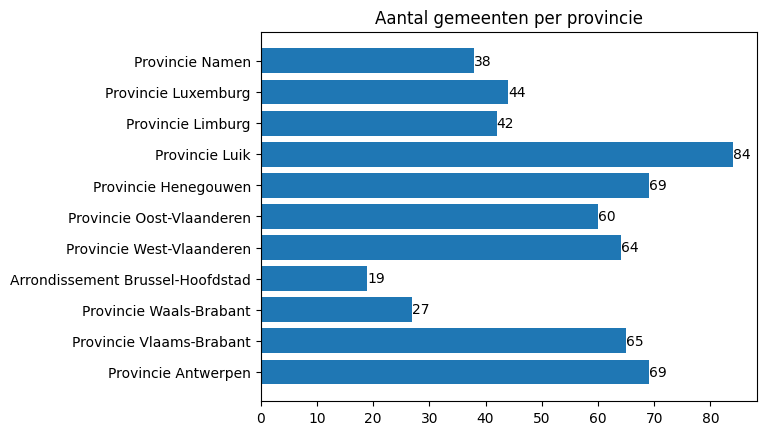

In [97]:
import matplotlib.pyplot as plt
bars = plt.barh(provincie_groepen.TX_REFNIS_NL, provincie_groepen.aantal, align='center')
plt.title('Aantal gemeenten per provincie')
plt.gca().bar_label(bars, label_type='edge')

plt.show()

In [ ]:

import pandas as pd
import requests
URL_M = 'https://statbel.fgov.be/sites/default/files/files/opendata/Voornamen%20pasgeborenen%20per%20gemeente/TA_BIRTHS_MALE_2015_2024.xlsx'
URL_F = 'https://statbel.fgov.be/sites/default/files/files/opendata/Voornamen%20pasgeborenen%20per%20gemeente/TA_BIRTHS_FEMALE_2015_2024.xlsx'
MALE_BIRTHS = 'TA_BIRTHS_MALE_2015_2024.xlsx'
FEMALE_BIRTHS = 'TA_BIRTS_FEMALE_2015_2024.xlsx'
data = requests.get(URL_M)
with open(MALE_BIRTHS, 'wb') as f:
    f.write(data.content)
data = requests.get(URL_F)
with open(FEMALE_BIRTHS, 'wb') as f:
    f.write(data.content)



NameError: name 'provincie_groepen' is not defined

In [2]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import openpyxl
male_wb = openpyxl.load_workbook(MALE_BIRTHS)
sheetnaam = male_wb.sheetnames[0]
worksheet = male_wb[sheetnaam]
laatste_rij = worksheet.max_row
df_jongens = pd.read_excel(MALE_BIRTHS, sheet_name=sheetnaam, nrows=laatste_rij)
female_wb = openpyxl.load_workbook(FEMALE_BIRTHS)
sheetname = female_wb.sheetnames[0]
worksheet = female_wb[sheetname]
laatste_rij = worksheet.max_row
df_meisjes = pd.read_excel(FEMALE_BIRTHS, sheet_name=sheetname, nrows=laatste_rij)
df_meisjes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19854 entries, 0 to 19853
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CD_REFNIS     19854 non-null  int64 
 1   tx_descr_nl   19854 non-null  object
 2   tx_descr_fr   19854 non-null  object
 3   TX_FST_NAME   19854 non-null  object
 4   MS_FREQUENCY  19854 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 775.7+ KB
